In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
#from dd_nnutil_hallym_batchcrop import *

In [2]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [3]:
tf.__version__

'2.3.0'

### Dataset 

In [4]:
#datadir = './dataset/handpose_20F_small_mini'
datadir = './dataset/handpose_20F_small'

python 에서 리눅스 명령어를 사용하려면 아래처럼 ! 로 시작
```
ls --> !ls
```

리눅스 명령어에 파이썬 변수를 사용하려면 $ 를 붙이고 사용
```
datadir --> $datadir
```

In [5]:
!ls $datadir

C0  C1	C2  C3	C4  C5


In [6]:
import datetime
def GetTimeString(m = -1):
    if m==0:
        s1 = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    else:
        s1 = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    return s1

In [7]:
import os
def MakeDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [8]:
MakeDir('out')

In [9]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def center_crop(img, crop_size):
    #width, height = img.size
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    
    new_width, new_height = crop_size [0], crop_size[1]
    
    x = int((width - new_width)/2)
    y = int((height - new_height)/2)
    dx = new_width
    dy = new_height
    #right = int((width + new_width)/2)
    #bottom = int((height + new_height)/2)

    return img[y:(y+dy), x:(x+dx), :]



def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    https://jkjung-avt.github.io/keras-image-cropping/
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            #batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
            batch_crops[i] = center_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

In [12]:
f = 2

In [13]:
train_generator = train_datagen.flow_from_directory(
        datadir,
        target_size=(300//f, 400//f),
        batch_size=32*4, 
        shuffle=True,
        class_mode='categorical' )

Found 12310 images belonging to 6 classes.


In [14]:
train_generator.class_indices

{'C0': 0, 'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5}

In [15]:
n_classes = len(train_generator.class_indices)
print(n_classes)

6


### Crop generator

In [16]:
train_crops = crop_generator(train_generator, 150) #224

In [17]:
#input_shape=(300//f, 400//f, 3)
#input_shape=(224, 224, 3)
input_shape=(150, 150, 3)

In [18]:
from skimage import io

def imshow(image_RGB, title=''):
    io.imshow(image_RGB)
    #io.set_title('a')
    plt.title(title)
    io.show()


20201214_122905


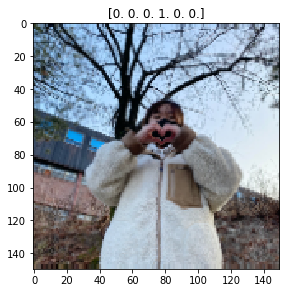

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_0_fig.png


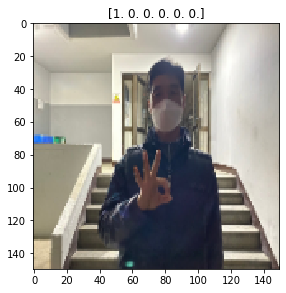

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_1_fig.png


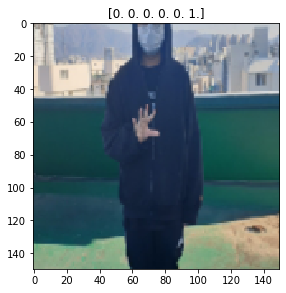

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_2_fig.png


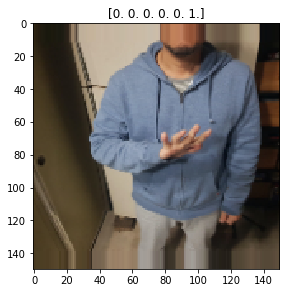

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_3_fig.png


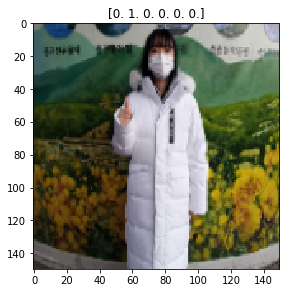

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_4_fig.png


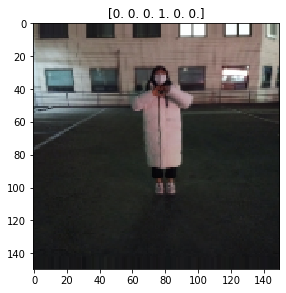

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_5_fig.png


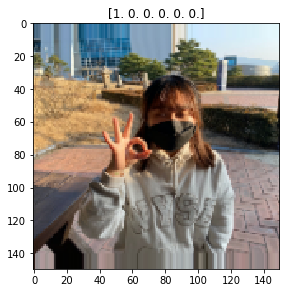

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_6_fig.png


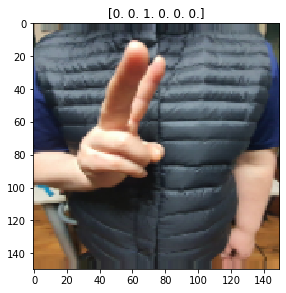

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_7_fig.png


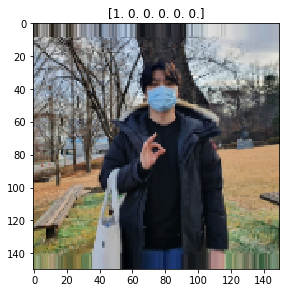

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_8_fig.png


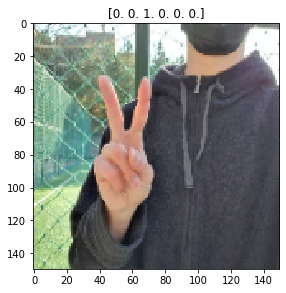

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


out/20201214_122905_9_fig.png


In [19]:
tstring = GetTimeString()#DDUtil
print(tstring)

#x,y = train_generator.next()
x,y = next(train_crops)

for i in range(0,10):
    image = x[i]
    f1=plt.figure()
    imshow(image, '{}'.format(y[i]))
    fnfig = 'out/{}_{}.png'.format(tstring, i)
    io.imsave(fnfig, image)
    #f1 = plt.gcf()
    fnfig = 'out/{}_{}_fig.png'.format(tstring, i)
    f1.savefig(fnfig)
    print(fnfig)
    

In [20]:
model = keras.Sequential([
    keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,(3,3),activation='relu'),
    #keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [21]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#history = model.fit_generator(train_generator, steps_per_epoch = 50, epochs=50)
history = model.fit_generator(train_crops, steps_per_epoch = 100, epochs=100)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
 85/100 [========================>.....] - ETA: 13s - loss: 1.7781 - accuracy: 0.1970

In [ ]:
import matplotlib.pyplot as plt


fig, loss_ax = plt.subplots(figsize=(10,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=1)
#loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=1)
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc', linewidth=1)
#acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc', linewidth=1)
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper center')
#plt.title(cellName[celltype])